In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
import tensorflow as tf

from datetime import datetime
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyDOE.doe_lhs import lhs
from scipy.interpolate import griddata
from scipy.optimize import minimize


pi = tf.constant(np.pi, dtype=tf.float32)

# Continuous Time Model of solution of Burguers' Equation $u(t, x)$

In [2]:
data = scipy.io.loadmat(os.path.join('.', 'Data', 'burgers_shock.mat'))

In [3]:
N_u = 100
N_f = 10000

In [4]:
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x, t)

# (x, t)
X_star = np.c_[X.flatten()[:, None], T.flatten()[:, None]]
u_star = Exact.flatten()[:, None]

# Domain bounds (x, t)
lb = X_star.min(0)
ub = X_star.max(0)  

In [5]:
xx1 = np.c_[X[0:1,:].T, T[0:1,:].T]
uu1 = Exact[0:1,:].T
xx2 = np.c_[X[:,0:1], T[:,0:1]]
uu2 = Exact[:,0:1]
xx3 = np.c_[X[:,-1:], T[:,-1:]]
uu3 = Exact[:,-1:]

X_u_train = np.r_[xx1, xx2, xx3]
X_f_train_ = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.r_[X_f_train_, X_u_train]

u_train = np.r_[uu1, uu2, uu3]

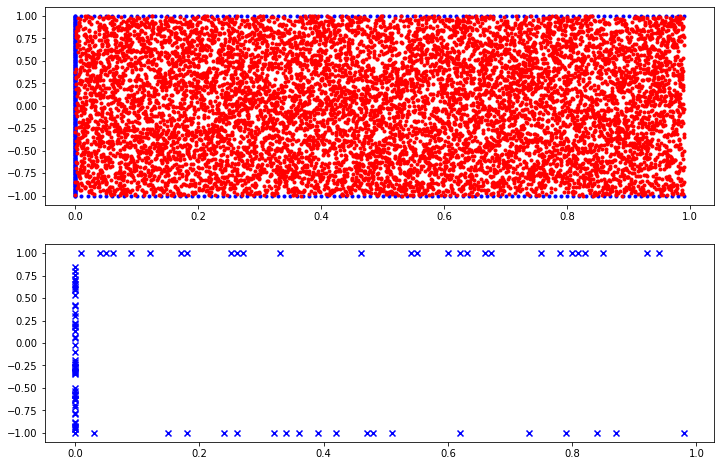

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.scatter(X_u_train[:, 1], X_u_train[:, 0], c='blue', marker='.')
ax1.scatter(X_f_train_[:, 1], X_f_train_[:, 0], c='red', marker='.')

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

ax2.scatter(X_u_train[:, 1], X_u_train[:, 0], c='blue', marker='x')

plt.show()

In [7]:
class NeuralNet(tf.keras.Model):
    def __init__(self, layers, ub, lb):
        super(NeuralNet, self).__init__()
        self.ub, self.lb = ub, lb
        self.input_layer = tf.keras.layers.Dense(units=layers[0], 
                                                 activation=tf.nn.tanh, 
                                                 kernel_initializer=tf.keras.initializers.HeNormal(), 
                                                 input_shape=(2,))
        self.hidden_layers = [tf.keras.layers.Dense(units=units, 
                                                    activation=tf.nn.tanh, 
                                                    kernel_initializer=tf.keras.initializers.HeNormal()) for units in layers[1:]]
        self.output_layer = tf.keras.layers.Dense(units=1, 
                                                  kernel_initializer=tf.keras.initializers.HeNormal())

    def call(self, x):
        x = 2. * (x - self.lb) / (self.ub - self.lb) - 1.
        x = self.input_layer(x)
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
        return self.output_layer(x)


layers = [20, 20, 20, 20, 20, 20, 20, 20]
neural_net = NeuralNet(layers, ub, lb)
u = neural_net(X_u_train)

In [8]:
neural_net.summary()

Model: "neural_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  60        
                                                                 
 dense_1 (Dense)             multiple                  420       
                                                                 
 dense_2 (Dense)             multiple                  420       
                                                                 
 dense_3 (Dense)             multiple                  420       
                                                                 
 dense_4 (Dense)             multiple                  420       
                                                                 
 dense_5 (Dense)             multiple                  420       
                                                                 
 dense_6 (Dense)             multiple                  4

In [9]:
@tf.function
def net_u(x, t):
    u = neural_net(tf.concat([x, t], 1))
    return u
    
@tf.function
def net_f(x, t):
    u = net_u(x, t)
    u_t = tf.gradients(u, t)[0]
    u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    f = u_t + u * u_x - (0.01 / pi) * u_xx
    return f
    
@tf.function
def loss_function(u_hat, f_hat, u):
    mse_u = tf.reduce_mean(tf.square(u - u_hat))
    mse_f = tf.reduce_mean(tf.square(f_hat))
    return mse_u + mse_f

@tf.function
def train_step(x_u, t_u, x_f, t_f, u):
    with tf.GradientTape() as tape:
        u_hat = net_u(x_u, t_u)
        f_hat = net_f(x_f, t_f)        
        loss = loss_function(u_hat, f_hat, u)
    
    grads = tape.gradient(loss, neural_net.trainable_variables)
    optimizer.apply_gradients(zip(grads, neural_net.trainable_variables))
    return loss

x_u = tf.convert_to_tensor(X_u_train[:, [0]], dtype=tf.float32)
t_u = tf.convert_to_tensor(X_u_train[:, [1]], dtype=tf.float32)

x_f = tf.convert_to_tensor(X_f_train[:, [0]], dtype=tf.float32)
t_f = tf.convert_to_tensor(X_f_train[:, [1]], dtype=tf.float32)

u = tf.convert_to_tensor(u_train, dtype=tf.float32)

## Using tensorflow optimizers

In [21]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.000001)

epochs = 20000
print_at_each = 1000
patience = 25

losses = []
start = datetime.now()

for epoch in range(epochs):
    current_loss = train_step(x_u, t_u, x_f, t_f, u)
    losses.append(current_loss)
    if epoch % print_at_each == (print_at_each - 1): 
        print(f'Epoch {epoch+1}, Loss: {current_loss}')
    
print(f'\nTime Elapsed: {datetime.now() - start}')

neural_net.save_weights('./model/model')

Epoch 1000, Loss: 7.129303867259296e-06
Epoch 2000, Loss: 7.007699423411395e-06
Epoch 3000, Loss: 6.892753390275175e-06
Epoch 4000, Loss: 6.779393515898846e-06
Epoch 5000, Loss: 6.674008545815013e-06
Epoch 6000, Loss: 6.568465323653072e-06
Epoch 7000, Loss: 6.467997991421726e-06
Epoch 8000, Loss: 6.373290489136707e-06
Epoch 9000, Loss: 6.2802291722618975e-06
Epoch 10000, Loss: 6.187539838720113e-06
Epoch 11000, Loss: 6.100200607761508e-06
Epoch 12000, Loss: 6.016959105181741e-06
Epoch 13000, Loss: 5.933923148404574e-06
Epoch 14000, Loss: 5.855059498571791e-06
Epoch 15000, Loss: 5.77782338950783e-06
Epoch 16000, Loss: 5.702112503058743e-06
Epoch 17000, Loss: 5.6295652939297725e-06
Epoch 18000, Loss: 5.5604173212486785e-06
Epoch 19000, Loss: 5.4925953918427695e-06
Epoch 20000, Loss: 5.422504727903288e-06

Time Elapsed: 0:14:41.436397


In [10]:
neural_net = NeuralNet(layers, ub, lb)

# Restore the weights
neural_net.load_weights('./model/model')

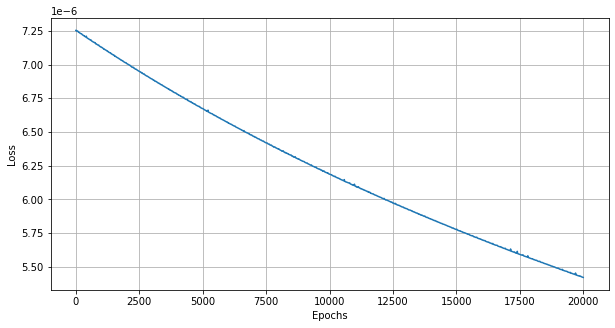

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(1, epochs+1), losses)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.grid()
plt.show()

## Paper code result

**Loss**: 2.8863915e-06  
**Loss**: 2.8863915e-06  
**Loss**: 2.8863915e-06  
**Loss**: 2.8863915e-06  
**Loss**: 2.8863915e-06  

Training time: 205.8400  

**Error u**: 2.734814e-03 (0.002734814)

Error u: 0.008135871810360065


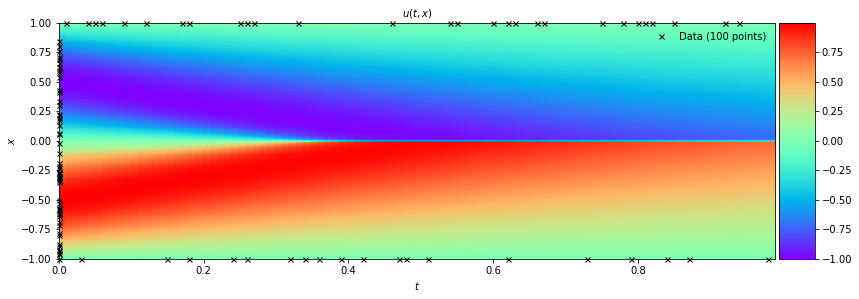

In [23]:
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

x_star = tf.convert_to_tensor(X_star[:, [0]], dtype=tf.float32)
t_star = tf.convert_to_tensor(X_star[:, [1]], dtype=tf.float32)

u_hat = net_u(x_star, t_star).numpy()
f_hat = net_f(x_star, t_star).numpy()

error_u = np.linalg.norm(u_star-u_hat, 2) / np.linalg.norm(u_star, 2)
print(f'Error u: {error_u}')  

U_pred = griddata(X_star, u_hat.flatten(), (X, T), method='cubic')


fig, ax = newfig(15, 12)
ax.axis('off')

################## u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', label=f'Data ({u_train.shape[0]} points)', markersize=5, clip_on=False)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc='upper right')
ax.set_title('$u(t,x)$', fontsize=10)

plt.show()

In [24]:
from IPython.display import display, HTML

fig, ax = plt.subplots(figsize=(7, 6))

def animation_func(t):
    error_u = np.linalg.norm(Exact[t, :] - U_pred[t, :], 2) / np.linalg.norm(Exact[t, :], 2)
    ax.clear()
    ax.plot(x, U_pred[t, :], label='Prediction', c='red')
    ax.plot(x, Exact[t, :], label='Exact', c='blue')
    ax.set_xlim((-1., 1.))
    ax.set_ylim((-1.05, 1.05))
    ax.set_title('$t = 0.{}$, $error = {}$'.format(t, np.round(error_u, 4)))
    ax.legend(frameon=False, loc='upper right')
    ax.grid()

anim = FuncAnimation(ax.figure, animation_func, frames=np.arange(1, 100), interval=75)
display(HTML(anim.to_jshtml(default_mode='once')))
plt.close()